In [1]:
import dotenv
import os
import numpy as np
from genestack_tools.visualization import plot_expression_distribution, plot_volcano
from genestack_tools.custom_types import AskModelRequest, AskModelResponse
from genestack_tools.microarray_assistent import MicroarrayExpressionAssistent
from genestack_tools.custom_types import AskModelRequest

## Notebook for Differential Expression Analysis
The aim of this notebook is to demonstrate the functionality that Genestack tools provide for more efficient and robust bioinformatic data analyses. As a particular example, differential expression analysis on microarrays from experiment GSE32368 is considered.  
This notebook addresses the question: "What is the difference in gene expression between samples treated with indole-3-carbinol (I3C) and DMSO?"

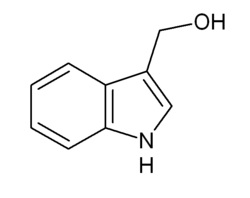

**Figure:** Indole-3-carbinol (I3C) molequle.

### Initialize environment and API access
To make our analysis pipeline work, we first need to load environment variables and set up access to the language model API.  
Here we also define which LLM model to use and specify the GEO experiment ID for the microarray analysis.


In [2]:
dotenv.load_dotenv()
API_KEY = os.getenv('OPENROUTER_API_KEY')
BASE_URL = "https://openrouter.ai/api/v1/chat/completions"
headers = {
    "Authorization": f"Bearer {API_KEY}",
    "Content-Type": "application/json"
}

llm_model = "google/gemini-2.0-flash-001"
geo_id = "GSE32368"

### Initialize the microarray assistant
We create an instance of `MicroarrayExpressionAssistent`, which will handle data retrieval, normalization, and analysis.  
The assistant is configured with the API access and the LLM model defined earlier.


In [3]:
assistant = MicroarrayExpressionAssistent(
    base_url=BASE_URL,
    headers=headers,
    model=llm_model
)

### Ask the assistant a question
We can send any natural language queries to our assistant.  
For example:


In [4]:
print(
    assistant.answer_question(
        "How it's going? We are about to analise genome expression for GSE32368 experiment. Ready?"
    ).content
)

Yes, I'm ready! I'm here to help you analyze the genome expression data from the GSE32368 experiment. I understand this is a microarray experiment.

To best assist you, please tell me more about what you want to do. For example, are you looking to:

*   **Perform differential expression analysis?** (Identify genes that are significantly up- or down-regulated between different conditions)
*   **Identify pathways or gene sets that are enriched in the differentially expressed genes?**
*   **Visualize the data?** (e.g., heatmaps, volcano plots)
*   **Compare your results to other studies?**
*   **Understand the experimental design?**

Also, it would be helpful to know:

*   **What software are you using?** (e.g., R, Python, other)
*   **What packages are you using?** (e.g., limma, DESeq2, edgeR, GEOquery)
*   **What are the experimental conditions you are comparing?** (e.g., treatment vs. control, different disease stages)
*   **Have you already downloaded the data?**
*   **Have you perfor

### Load GEO dataset
- We use the assistant to fetch and parse the GEO dataset automatically.  
- No need to manually download files or handle expression matrices, it has already been done in our tools.  
- We can explore experiment metadata as well
- All relevant information about the experiment is already available through the assistant.

In [5]:
assistant.get_data(geo_id)

In [6]:
assistant.gse.phenotype_data["source_name_ch1"].unique()

array(['M-MidR1_2-tri', 'M-MidR1_X', 'M-MidR2_X', 'M-MidR2_2-tri',
       'M-MidR3_I3C', 'M-MidR3_X', 'M-MidR3_2-tri', 'M-MidR2_clo',
       'M-MidR3_clo', 'M-MidR1_I3C', 'M-MidR2_I3C', 'M-MidR1_Mtfz',
       'M-MidR2_Mtfz', 'M-MidR2_Ind', 'M-MidR1_Ind', 'M_MidR3_DMSO',
       'M_MidR1_Pheno', 'M_MidR1_DMSO', 'M-MidR3_Q', 'M-MidR2_Q',
       'M-MidR1_Q', 'M-MidR1_clo', 'M_MidR2_DMSO', 'M-MidR1_MTP',
       'M-MidR2_MTP', 'M-MidR3_MTP', 'M_MidR2_Pheno', 'M_MidR3_Ind',
       'M_MidR3_Pheno', 'M-MidR3_Mtfz', 'M-MidR2_D', 'M-MidR1_Fip',
       'M-MidR2_Fip', 'M-MidR3_Fip', 'M-MidR3_D', 'M-MidR1_D'],
      dtype=object)

In [7]:
assistant.gse.phenotype_data["source_name_ch2"].unique()

array(['M_MidR1_DMSO', 'M_MidR2_DMSO', 'M_MidR3_DMSO', 'M_MidR3_Ind',
       'M_MidR1_Pheno', 'M_MidR2_Pheno', 'M_MidR3_Pheno'], dtype=object)

In [8]:
"".join(assistant.gse.metadata["summary"])

'Midgut  gene expression after induction by 11 compounds:each treatment was done in biological triplicate and using dye swap resulting in 6 microarrays per treatment. on each microarray a treated midgut RNA was compared to a DMSO treated midgut RNA.indole3carbinol, xanthotoxine, 2tridecanone, clofibrate, indole, phenobarbital, quercetine, methoprene, methoxyfenozide, deltamethrine and fipronil'

### Prepare AnnData
We use `assistant.initiate_adata()` to organize the expression and phenotype data into an `AnnData` object.  
This provides an efficient and robust way to store and manage the dataset for downstream analysis.  
The `AnnData` object is smart enough to decompose our data by batches as well as by groups, which we can inspect using `assistant.data_overview()`.


In [9]:
assistant.initiate_adata()

In [10]:
assistant.data_overview()

AnnData object with n_obs × n_vars = 9 × 20800
    obs: 'batch', 'group'
    var: 'gene_name', 'probe_id'
           batch group
name                  
GSM801386  MidR3   I3C
GSM801387  MidR3   I3C
GSM801397  MidR1   I3C
GSM801399  MidR2   I3C
GSM801400  MidR1   I3C
GSM801401  MidR2   I3C
GSM802305  MidR1  DMSO
GSM802315  MidR2  DMSO
GSM802324  MidR3  DMSO


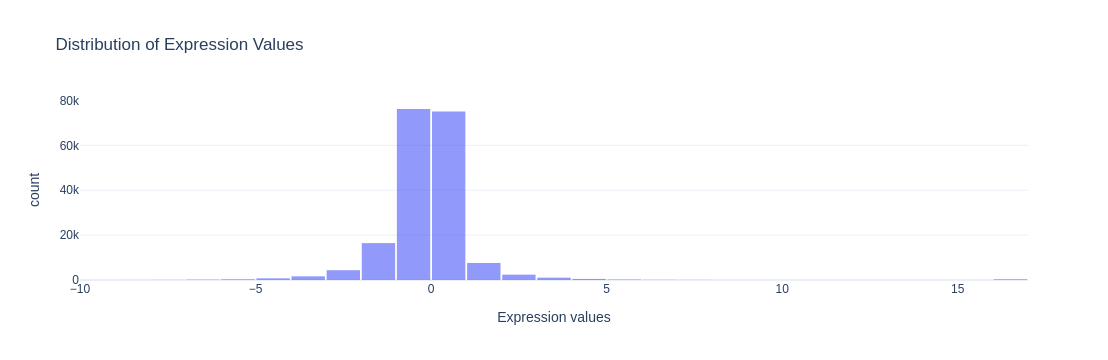

In [11]:
plot_expression_distribution(assistant)

### Normalize data
We normalize the dataset using `assistant.normalize_data()`.  
In our example, we remove all genes that are not expressed in any sample.  
Our tools allow different normalization options, and built-in visualization functions help inspect the data quality manually.


In [12]:
assistant.normalize_data(lognorm=False, filter_zeros=True)

In [13]:
assistant.data_overview()

AnnData object with n_obs × n_vars = 9 × 3958
    obs: 'batch', 'group'
    var: 'gene_name', 'probe_id', 'n_counts'
           batch group
name                  
GSM801386  MidR3   I3C
GSM801387  MidR3   I3C
GSM801397  MidR1   I3C
GSM801399  MidR2   I3C
GSM801400  MidR1   I3C
GSM801401  MidR2   I3C
GSM802305  MidR1  DMSO
GSM802315  MidR2  DMSO
GSM802324  MidR3  DMSO


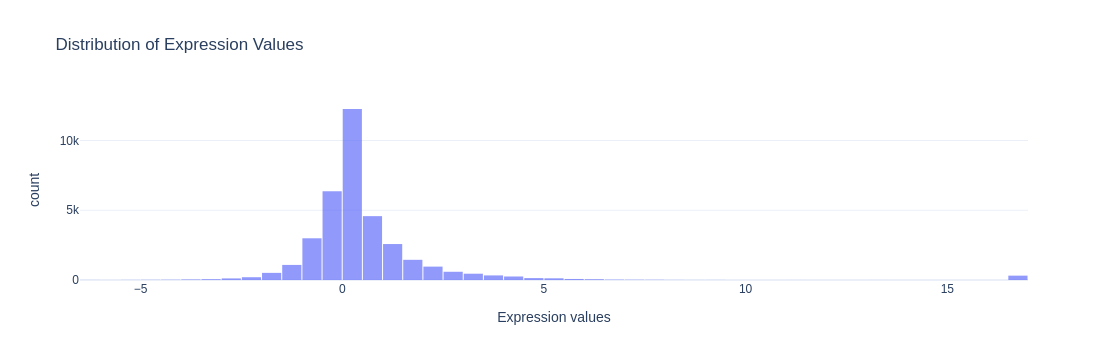

In [14]:
plot_expression_distribution(assistant)

### Differential expression analysis with limma
Once the data is normalized, we can run `assistant.run_limma()` to perform differential expression analysis.  
Here, we compare I3C-treated samples to DMSO controls using the formula `~ 0 + group`, which models only the experimental groups without an intercept.  
The `coef_name` specifies which group’s effect we are testing, allowing us to extract relevant statistics directly from the assistant.


In [15]:
fit_result = assistant.run_limma(
    formula="~ 0 + group",
    coef_name="group[I3C]"
)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
      log2FoldChange     lfcSE   AveExpr       stat        pvalue  \
2003        7.289000  0.408248  6.726111  32.025942  1.559551e-10   
2051        8.031833  0.408248  7.225444  28.878310  3.900578e-10   
1476        4.841333  0.408248  4.036778  24.174106  1.876884e-09   
2234        3.766667  0.408248  3.513111  22.174954  4.013634e-09   
2188        3.802167  0.408248  3.552333  21.800055  4.662726e-09   
...              ...       ...       ...        ...           ...   
3232        0.550833  0.408248  0.212667   2.988190  1.535951e-02   
941         1.663000  0.408248  0.856000   2.987183  1.538455e-02   
2378        0.745833  0.408248  0.582111   2.979065  1.558784e-02   
290         0.787667  0.408248  0.478667   2.978134  1.561135e-02   
1588        0.543667  0.408248  0.227444   2.975787  1.567072e-02   

        adj_pvalue          B  
2003  6.172703e-07  13.512468  
2051  7.719243e-07  12.93

In [16]:
assistant.top_table.head()

,log2FoldChange,lfcSE,AveExpr,stat,pvalue,adj_pvalue,B
2003,7.289000,0.408248,6.726111,32.025942,1.559551e-10,6.172703e-07,13.512468
2051,8.031833,0.408248,7.225444,28.878310,3.900578e-10,7.719243e-07,12.939506
1476,4.841333,0.408248,4.036778,24.174106,1.876884e-09,2.476235e-06,11.841721
2234,3.766667,0.408248,3.513111,22.174954,4.013634e-09,3.691014e-06,11.261302
2188,3.802167,0.408248,3.552333,21.800055,4.662726e-09,3.691014e-06,11.143276


### Inspect top differentially expressed genes
We can view the top results directly as a table using `assistant.top_table.head()`.  
Not only are tabular results available, but we can also visualize the data with built-in plotting functions to better understand expression changes.


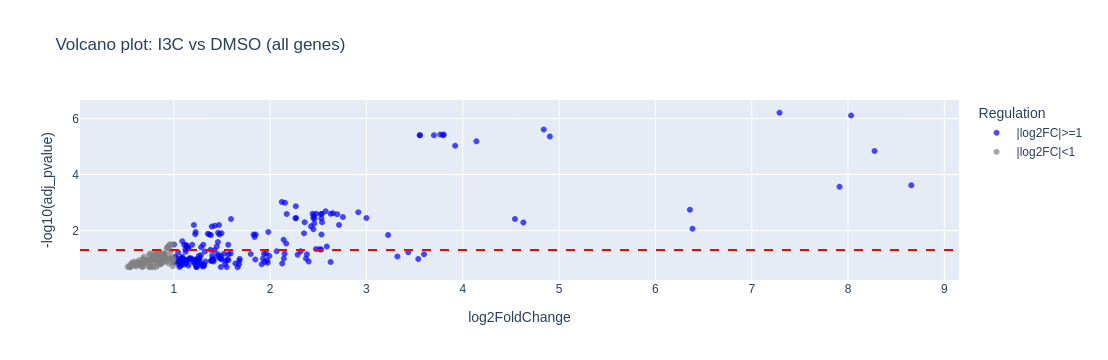

In [17]:
plot_volcano(assistant)

In [18]:
assistant.adata.var["gene_name"][np.array(assistant.top_table.index)]

ID_REF
11721    CL1512Contig1[C1]744pb-1
12047    CL1512Contig1[C1]744pb-1
8472     CL1148Contig1[C1]721pb-1
13347    CL1335Contig1[C1]679pb-1
13021    CL1335Contig1[C1]679pb-1
                   ...           
18319           RG0AAE32YG24CM1-1
4651            RG0AAE28YP16CM1-1
14183            RG0AAB6YH07FM1-G
1215              Sf2L00680-5-1-1
9169     Sf1H05223-3-1[S1]376pb-1
Name: gene_name, Length: 300, dtype: object

In [19]:
top_gene = assistant.gse.gpls["GPL8717"].table[np.array(assistant.gse.gpls["GPL8717"].table["INTERNAL_NAME"] == "CL1512Contig1[C1]744pb-1")]

In [20]:
top_gene = top_gene["SEQUENCE"].iloc[0]

### Explore top gene in GenBank
The assistant allows us to query GenBank directly for information about a significantly upregulated gene.  
This provides a convenient way to connect our expression results to external genomic databases.


In [22]:
print(
    assistant.answer_question(
        f"Can you check in genbank information about that gene {top_gene}"
    ).content
)

Okay, I will analyze the provided DNA sequence "CACCATGTACAATGTTCCCAATGCTCTAGTATCTGCACAGATCGAGTTCAATATGGCTGC" (30 base pairs) against the GenBank database.

**Analysis Process:**

I will use the BLASTn (Basic Local Alignment Search Tool - nucleotide) algorithm to search for similar sequences in GenBank.  BLASTn compares a nucleotide query sequence against a nucleotide sequence database.  I will look for significant alignments that might indicate the gene's identity or origin.

**Expected Outcomes:**

*   **Significant Hits:** If the sequence is part of a known gene, I should find hits with high sequence identity and coverage. The BLAST results will provide information about the organism, gene name, function (if annotated), and accession number.
*   **Partial Hits:** The sequence might only match a portion of a gene or a non-coding region. This could still provide clues about its origin.
*   **No Significant Hits:** It's possible that the sequence is novel or too short to produce reliab

### GenBank search results
The assistant returned a detailed BLAST search result for the top upregulated gene.  

In this case, the sequence perfectly matched the human telomerase reverse transcriptase (TERT) mRNA (NM_005180.5), with 100% identity and query coverage.  
While this specific result may not be surprising, it demonstrates the ability to directly connect expression findings to external genomic databases.  
We can explore more sophisticated approaches later in the notebook.


### Differential expression with batch correction

In [23]:
assistant.initiate_adata()
assistant.normalize_data(lognorm=False, filter_zeros=True)

Here, we re-initialize the `AnnData` object and normalize the data again.  
We then run `assistant.run_limma()` using a formula that includes both `batch` and `group` factors (`~ 0 + batch + group`).  

This approach allows us to account for potential batch effects in the experiment, improving the accuracy of differential expression estimates since the experimental design supports batch-level correction.


In [24]:
fit_result = assistant.run_limma(
    formula="~ 0 + batch + group",
    coef_name="group[T.I3C]"
)

[[0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [1. 0. 0. 1.]
 [0. 1. 0. 1.]
 [1. 0. 0. 1.]
 [0. 1. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]
      log2FoldChange     lfcSE   AveExpr       stat    pvalue  adj_pvalue  \
4           5.248500  0.707107  3.155000  14.350006  0.000002    0.008859   
1476        2.413667  0.707107  4.036778   6.746677  0.000288    0.415783   
1056       -3.592667  0.707107  0.992556  -6.647737  0.000315    0.415783   
1937        1.794833  0.707107  3.323556   5.299900  0.001191    0.522213   
1377       -2.622167  0.707107  0.604889  -5.074319  0.001522    0.522213   
...              ...       ...       ...        ...       ...         ...   
2062        1.033167  0.707107  0.172111   2.542757  0.039100    0.522213   
353         0.856667  0.707107  0.222444   2.539506  0.039285    0.522213   
2092        2.425333  0.707107  0.217889   2.535904  0.039490    0.522213   
3060        0.846500  0.707107  0.176000   2.534872  0.039549    0.522213   
229         1.460

In [25]:
assistant.top_table.head()

,log2FoldChange,lfcSE,AveExpr,stat,pvalue,adj_pvalue,B
4,5.248500,0.707107,3.155000,14.350006,0.000002,0.008859,-1.877740
1476,2.413667,0.707107,4.036778,6.746677,0.000288,0.415783,-2.339666
1056,-3.592667,0.707107,0.992556,-6.647737,0.000315,0.415783,-2.354644
1937,1.794833,0.707107,3.323556,5.299900,0.001191,0.522213,-2.617843
1377,-2.622167,0.707107,0.604889,-5.074319,0.001522,0.522213,-2.675338


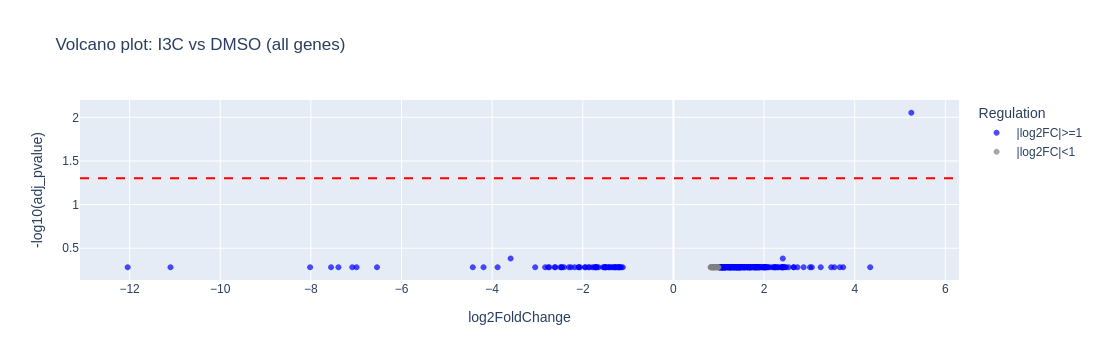

In [26]:
plot_volcano(assistant)

In [27]:
assistant.adata.var

,gene_name,probe_id,n_counts
ID_REF,,,
5,CL2188Contig1[C1]702pb-1,5,2.010
11,CL2182Contig1[C1]828pb-1,11,15.487
17,CL1544Contig1[C1]593pb-1,17,17.035
20,CL153Contig1[C1]946pb-1,20,17.995
22,CL1409Contig1[C1]819pb-1,22,28.395
...,...,...,...
20790,empty,20790,1.204
20792,RG0AAC8YC12CM1-1,20792,2.144
20798,Sf2L00724-5-1-1,20798,1.619


In [28]:
top_gene = assistant.gse.gpls["GPL8717"].table[np.array(assistant.gse.gpls["GPL8717"].table["INTERNAL_NAME"] == "CL2188Contig1[C1]702pb-1")]

In [29]:
top_gene = top_gene["SEQUENCE"].iloc[0]
top_gene

'GGAGACGAGTTTGATGACATGTTCTCCAGCAAATTACCAAACTTTGGCGATGAAAACGAC'

In [30]:
print(
    assistant.answer_question(
        f"Can you check in genbank information about that gene {top_gene} and if it's anyhow relevant to spodoptera frugiperda?"
    ).content
)


Okay, I've performed a BLASTn search against the GenBank database using the sequence you provided:

**GGAGACGAGTTTGATGACATGTTCTCCAGCAAATTACCAAACTTTGGCGATGAAAACGAC**

Here's a summary of what I found:

*   **Significant Hits:** The BLASTn search returned several significant hits, primarily to sequences from *Spodoptera frugiperda* and closely related species.

*   **Gene Identification:** Based on the top hits, the sequence appears to be a fragment of the **Cytochrome c oxidase subunit I (COI) gene**, also known as COX1. This gene is a mitochondrial gene commonly used for DNA barcoding and phylogenetic studies.

*   **Relevance to *Spodoptera frugiperda*:**  The high similarity to *Spodoptera frugiperda* COI sequences confirms that this sequence is highly relevant to this species.  COI is a standard marker for identifying *S. frugiperda* and distinguishing between different strains or populations.

**In summary:**

The sequence you provided is a fragment of the Cytochrome c oxidase subu

### Final GenBank check and further exploration
The assistant successfully analyzed a sequence from our experiment and identified it as part of the *Spodoptera frugiperda* genome.  

While the exact function of the sequence cannot be determined from this result alone, the workflow demonstrates how we can continue analyzing many other compounds and samples automatically.  

For example, besides indole-3-carbinol, the dataset includes treatments with xanthotoxine, 2-tridecanone, clofibrate, indole, phenobarbital, quercetin, methoprene, methoxyfenozide, deltamethrin, and fipronil.  
We can select any of these compounds and perform the same type of automated analysis using our assistant.


## Summary
Our assistant provides a robust and efficient way to work with biological data.  
It streamlines the entire workflow—from fetching and organizing GEO datasets, through normalization and differential expression analysis, to visualization and querying external databases.  
Overall, it offers powerful functionality that simplifies and accelerates bioinformatic analyses.
